In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session

# uncomment if you wanna use the tranfer entropy measure
import sys
testdir = os.getcwd() # os.path.dirname(__file__)
import smite

# fix slow autocomplete
%config Completer.use_jedi = False
%matplotlib inline

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"
    data_root = "/run/media/tom.chartrand/Brain2019"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

 
cache = EcephysProjectCache.fixed(manifest=manifest_path)

#from aux_fun import get_binned_spike_trains
#from sanity_check import sanity_check


In [2]:
def get_binned_spike_trains(cache,session_id,stim_type,time_step=1/100):
    """obtain the binned spike trains for a given session in cache and a given stimulus type
    """
    import numpy as np

    session = cache.get_session_data(session_id)
    my_units = session.units #[session.units.structure_acronym==rec_area]
    #my_units = my_units.sort_index(by='probe_vertical_position')
    my_stim = session.get_presentations_for_stimulus(stim_type)
    first_id = my_stim.index.values[0]
    first_duration = my_stim.loc[first_id, "stop_time"] - my_stim.loc[first_id, "start_time"]
    time_domain = np.arange(0.0, first_duration + time_step, time_step)
    histograms = session.presentationwise_spike_counts(bin_edges=time_domain,stimulus_presentation_ids=my_stim.index,
        unit_ids=my_units.index.values)
    T_histo = histograms.transpose()
    return T_histo,my_units

def get_binned_spike_trains_sorted(cache,session_id,stim_type,time_step=1/100):
    """obtain the binned spike trains for a given session in cache and a given stimulus type
    """
    import numpy as np

    session = cache.get_session_data(session_id)
    my_units = session.units #[session.units.structure_acronym==rec_area]
    my_units = my_units.sort_values(by=['probe_vertical_position'], ascending = False)
    my_stim = session.get_presentations_for_stimulus(stim_type)
    first_id = my_stim.index.values[0]
    first_duration = my_stim.loc[first_id, "stop_time"] - my_stim.loc[first_id, "start_time"]
    time_domain = np.arange(0.0, first_duration + time_step, time_step)
    histograms = session.presentationwise_spike_counts(bin_edges=time_domain,stimulus_presentation_ids=my_stim.index,
        unit_ids=my_units.index.values)
    T_histo = histograms.transpose()
    return T_histo,my_units



In [36]:
session_id=737581020
stim_type='drifting_gratings'#''#'spontaneous'natural_scenes''drifting_gratings
time_step = 1/100

areas1 = ['VISp']
areas2 = ['VISp','VISl','VISl','VISal','VISrl','VISam','VISpm']

T,units = get_binned_spike_trains_sorted(cache,session_id,stim_type,time_step)

/Users/matthewbuchan/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [50]:
#select a specific stim 
session = cache.get_session_data(session_id)
stim_table = session.get_presentations_for_stimulus(stim_type)
stim_ids = stim_table.index.values
if stim_type == 'natural_scenes':
    print('natural scenes')
    stim_cond = stim_conditions = stim_table.stimulus_condition_id.values
    unique_cond = stim_table.stimulus_condition_id.unique()
    frames = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=False)
elif stim_type == 'drifting_gratings':
    print('drifting')
    unique_cond = stim_table.orientation.unique()
    unique_cond = unique_cond[unique_cond !='null']
    stim_cond = stim_conditions = stim_table.orientation.values




/Users/matthewbuchan/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


drifting


In [51]:
# for each stimulus in frames average across trials 
num_stims = len(unique_cond)
Avg_psth = np.zeros((T.shape[0],T.shape[1],num_stims))
for ix,cond in enumerate(unique_cond):
    #print(ix)
    idx_in = stim_cond == cond
    #print(sum(idx_in))
    Avg_psth[:,:,ix] = np.nanmean(T[:,:,idx_in],2)

In [53]:
units['Row_number'] = np.arange(len(units))
unitIDs1 = []
unitIDs2 = []
for index in units.index:
    structure_acronym = units.structure_acronym[index]
    if structure_acronym in areas1:
        unitIDs1.append(index)    
    if structure_acronym in areas2:
        unitIDs2.append(index)    

unit_ind1 = units.Row_number[unitIDs1].values
unit_ind2 = units.Row_number[unitIDs2].values

N1 = len(unitIDs1)
N2 = len(unitIDs2)

In [59]:
XX = Avg_psth
import scipy.stats as stats
import statsmodels as statsmodels
from statsmodels import tsa
from statsmodels.tsa import stattools

corr_mat = np.zeros([N1,N2,8])

for itrial in range(8):
    print(itrial)
    for i in range(N1):
        for j in range(N2):

            symX = symbolize(XX[unit_ind1[i],:,itrial],3)
            symY = symbolize(XX[unit_ind2[j],:,itrial],3)

            TXY = symbolic_transfer_entropy(symX, symY)
            TYX = symbolic_transfer_entropy(symY, symX)
            
            corr_mat[i,j,itrial]= TYX - TXY

            
            
import pickle

def save_object(obj, filename):
     with open(filename, 'wb') as output:  
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
        

save_object(corr_mat, str('corr_mat_' + stim_type + 'session_' + str(session_id) +'.pkl'))   



0
1
2
3
4
5
6
7


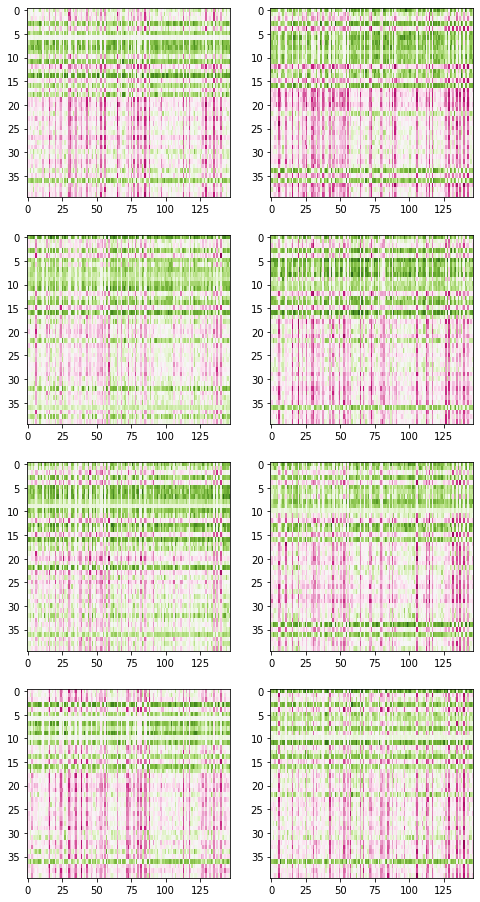

In [60]:
fig,ax = plt.subplots(4, 2, figsize=(8,16))
ax = ax.ravel()

for i, a in enumerate(ax):
    a.imshow(corr_mat[:,:,i], aspect="auto", cmap=plt.get_cmap('PiYG'))
    

In [61]:
session_TE = np.mean(corr_mat, axis = 2)

In [110]:
np.save('session_TE', session_TE, allow_pickle= False)

AttributeError: module 'pickle' has no attribute 'save_object'

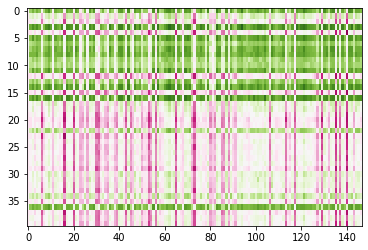

In [117]:
plt.imshow(session_TE, cmap = "PiYG", aspect = 'auto')

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(session_TE)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [63]:
pca.explained_variance_
print(pca.explained_variance_ratio_)
pca.components_ #eigenvectors
X_project = pca.fit_transform(session_TE)
max_pc = 3

[9.67595453e-01 1.08041401e-02 1.39300226e-03 1.26312491e-03
 1.22129265e-03 1.06175349e-03 1.02839703e-03 9.95243676e-04
 9.70012178e-04 9.19446254e-04 8.44433901e-04 8.24857677e-04
 7.85959604e-04 7.59895472e-04 6.96992821e-04 6.46965090e-04
 6.14405003e-04 5.79135559e-04 5.52180783e-04 5.28716822e-04]


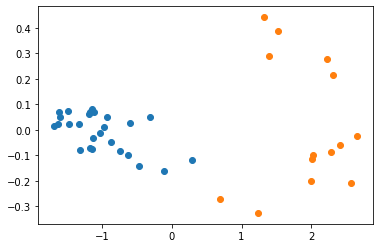

In [90]:
from sklearn.cluster import KMeans
from scipy import stats

kmeans = KMeans(n_clusters=2).fit(X_project[:,:3])
unsupervised_y_hat = kmeans.labels_

# plot_test_performance(X_project,y,sorted_unsup_y_hat)
plt.scatter(X_project[unsupervised_y_hat==0,0],X_project[unsupervised_y_hat==0,1])
plt.scatter(X_project[unsupervised_y_hat==1,0],X_project[unsupervised_y_hat==1,1])
plt.scatter(X_project[unsupervised_y_hat==2,0],X_project[unsupervised_y_hat==2,1])

In [104]:
sort_id = np.argsort(unsupervised_y_hat)
sort_id


array([19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 20,
       38, 39, 17,  1, 15,  2, 12,  4, 18, 36,  3,  5,  6,  8,  9, 10, 11,
       13, 14, 22, 16,  7,  0])

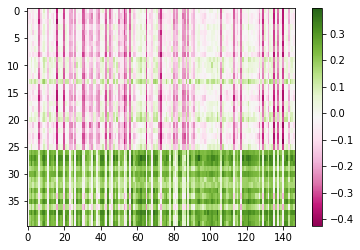

In [97]:
plt.imshow(session_TE[sort_id], cmap=plt.get_cmap('PiYG'), aspect = 'auto')
plt.colorbar()

In [84]:
session_units = session.units
VISp_units = session_units[session_units.structure_acronym == "VISp"]
VISp_units = VISp_units.sort_values(by = ['probe_vertical_position'], ascending = False)
VISp_units['cluster'] = unsupervised_y_hat

In [111]:
VISp_units.to_pickle("VISp_unit_clusters")

In [114]:
session_units.to_pickle("all_units")

In [126]:
all_visual_units = units.loc[unitIDs2]

In [127]:
all_visual_units

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate,Row_number
unit_id,,,,,,,,,,,,,,,,,,,,,
914617080,0.260099,182.880360,0.000118,448,33.68,4.969710,0.235628,0.000000,52.744115,0.000888,...,VISrl,417.0,59,757988398,3480,probeE,2500.000036,,30000.000435,0
914617054,4.997922,165.348885,0.000725,435,47.99,6.898380,27.447800,0.004129,186.845410,0.000570,...,VISrl,417.0,59,757988398,3400,probeE,2500.000036,,30000.000435,1
914617046,0.599172,158.720055,0.000626,431,97.40,4.551243,16.250600,0.016370,89.301975,0.028733,...,VISrl,417.0,11,757988398,3340,probeE,2500.000036,,30000.000435,2
914617176,0.328609,134.543760,0.007900,496,203.24,4.148972,1.789849,0.113501,40.044760,0.033568,...,VISrl,417.0,59,757988398,3280,probeE,2500.000036,,30000.000435,3
914617038,0.316477,90.938640,0.016133,427,207.07,3.023603,2.888658,0.426071,40.308433,0.045373,...,VISrl,417.0,59,757988398,3280,probeE,2500.000036,,30000.000435,4
914617032,1.665990,96.002985,0.056477,424,127.61,3.612067,11.320081,0.040986,62.127991,0.010252,...,VISrl,417.0,59,757988398,3240,probeE,2500.000036,,30000.000435,5
914615132,0.340521,49.533120,0.034790,467,368.04,3.883598,1.226418,0.327738,39.236432,0.046510,...,VISp,385.0,27,757988391,3240,probeC,2499.999871,,29999.998448,6
914615240,0.263063,47.705385,0.039381,521,292.67,3.467218,2.485168,0.239449,51.954025,0.018182,...,VISp,385.0,11,757988391,3220,probeC,2499.999871,,29999.998448,7
914615116,0.156496,53.904045,0.013805,459,105.45,3.723802,10.710719,0.030079,74.287969,0.013771,...,VISp,385.0,43,757988391,3220,probeC,2499.999871,,29999.998448,8
